In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib as mpl
import cv2
import time
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.initializers import glorot_normal
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
from matplotlib import pyplot
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
"""
Calculates dot product of x[0] and x[1] for mini_batch 

Assuming both have same size and shape

@param
x -> [ (size_minibatch, total_pixels, size_filter), (size_minibatch, total_pixels, size_filter) ]

"""
def dot_product(x):

    return keras.backend.batch_dot(x[0], x[1], axes=[1,1]) / x[0].get_shape().as_list()[1] 

"""
Calculate signed square root

@param
x -> a tensor

"""

def signed_sqrt(x):

    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

"""
Calculate L2-norm

@param
x -> a tensor

"""

def L2_norm(x, axis=-1):

    return keras.backend.l2_normalize(x, axis=axis)

In [65]:
'''

    Take outputs of last layer of VGG and Droput 50% 
    load it into Lambda layer which calculates outer product.
    
    Here both bi-linear branches have same shape.
    
    z -> output shape tuple
    x -> outpur og VGG tensor
    y -> copy of x as we modify x, we use x, y for outer product.
    
'''

def build_model():
    tensor_input = keras.layers.Input(shape=[150,150,3])
    
    model1 = tf.keras.models.Sequential()
    model1 = layers.Conv2D(32, (3, 3), activation='relu')(tensor_input)
    model1 = (layers.MaxPooling2D((2, 2)))(model1)
    model1 = (layers.Conv2D(64, (3, 3), activation='relu'))(model1)
    model1 = (layers.MaxPooling2D((2, 2)))(model1)
    model1 = (layers.Conv2D(64, (3, 3), activation='relu'))(model1)
    model1 = keras.models.Model(inputs=tensor_input, outputs = model1)
    
    print(model1.summary())

    
    model2 = tf.keras.models.Sequential()
    model2 = layers.Conv2D(32, (3, 3), activation='relu')(tensor_input)
    model2 = (layers.MaxPooling2D((2, 2)))(model2)
    model2 = (layers.Conv2D(64, (3, 3), activation='relu'))(model2)
    model2 = (layers.MaxPooling2D((2, 2)))(model2)
    model2 = (layers.Conv2D(64, (3, 3), activation='relu'))(model2)
    model2 = keras.models.Model(inputs=tensor_input, outputs = model2)

    print(model2.summary())
    
    x = model1.output
    z = model2.output_shape
    y = model2.output
    

#   rehape to (batch_size, total_pixels, filter_size)
    x = keras.layers.Reshape([z[1] * z[2] , z[-1]])(x)
        
    y = keras.layers.Reshape([z[1] * z[2] , z[-1]])(y)
    
#   outer products of x, y
    x = keras.layers.Lambda(dot_product)([x, y])
    
#   rehape to (batch_size, filter_size_vgg_last_layer*filter_vgg_last_layer)
    x = keras.layers.Reshape([z[-1]*z[-1]])(x)
        
#   signed_sqrt
    x = keras.layers.Lambda(signed_sqrt)(x)
        
#   L2_norm
    x = keras.layers.Lambda(L2_norm)(x)

#   FC-Layer

    initializer = tf.keras.initializers.GlorotNormal()
            
    x = keras.layers.Dense(units=258, 
                           kernel_regularizer=keras.regularizers.l2(0.0),
                           kernel_initializer=initializer)(x)

    tensor_prediction = keras.layers.Activation("softmax")(x)

    model_bilinear = keras.models.Model(inputs=[tensor_input],
                                        outputs=[tensor_prediction])
    


    sgd = keras.optimizers.SGD(lr=1.0, 
                               decay=0.0,
                               momentum=0.9)

    model_bilinear.compile(loss="categorical_crossentropy", 
                           optimizer=sgd,
                           metrics=["categorical_accuracy"])

    model_bilinear.summary()
    
    return model_bilinear

In [66]:
model = build_model()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 34, 34, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
______________________________________________________

D:\project\src\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [67]:

def train_model(epochs):

    hist = model.fit_generator(
                train_generator, 
                epochs=epochs, 
                validation_data=val_generator,
                workers=3,
                verbose=1
            )
        
#     model.save_weights("./bilinear_weights/val_acc_" + str(hist.history['val_categorical_accuracy'][-1]) +"_"+ str(epochs)+ ".h5")
    
    return hist



In [68]:
train_datagen = image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [69]:
train_generator = train_datagen.flow_from_directory(
        '../nut_snacks/dataset_split/train',
        target_size=(150, 150),
        color_mode="rgb",
        batch_size=32,
        subset='training',
        class_mode='categorical')
val_generator = test_datagen.flow_from_directory(
        '../nut_snacks/dataset_split/val',
        target_size=(150, 150),
        color_mode="rgb",
        batch_size=32,
        subset='training',
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        '../nut_snacks/dataset_split/test',
        target_size=(150, 150),
        color_mode="rgb",
        shuffle = False,
        class_mode=None,
        batch_size=1)

Found 6965 images belonging to 258 classes.
Found 1290 images belonging to 258 classes.
Found 2064 images belonging to 258 classes.


In [70]:
hist =train_model(epochs=1)

D:\project\src\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


218/218 [==============================] - 17s 65ms/step - loss: 5.6388 - categorical_accuracy: 0.0032 - val_loss: 5.6352 - val_categorical_accuracy: 0.0039


In [19]:
model.load_weights('./model_bilinear/BCNN_keras/E[30]_LOS[0.092]_ACC[0.974].hdf5')

In [20]:
for layer in model.layers:
    layer.trainable = True

sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-9, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy"])

In [27]:
hist =train_model(epochs=2)

Epoch 1/2
218/218 [==============================] - 52s 239ms/step - loss: 0.0235 - categorical_accuracy: 0.9990 - val_loss: 0.0836 - val_categorical_accuracy: 0.9775
Epoch 2/2
218/218 [==============================] - 52s 239ms/step - loss: 0.0233 - categorical_accuracy: 0.9986 - val_loss: 0.0905 - val_categorical_accuracy: 0.9736


In [28]:
model.save('./model_bilin_dropout')

INFO:tensorflow:Assets written to: ./model_bilin_dropout\assets


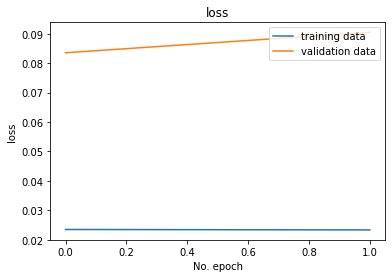

In [29]:
# Plot history: MAE
plt.plot(model.history.history['loss'], label='training data')
plt.plot(model.history.history['val_loss'], label='validation data')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [30]:
preds = model.predict_generator(test_generator, verbose=1)

D:\project\src\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2064/2064 [==============================] - 18s 8ms/step


In [31]:
preds_cls_idx = preds.argmax(axis=-1)
preds_cls_idx

array([  0,   0,   0, ...,   4, 257, 257], dtype=int64)

In [32]:
idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
preds_cls

array(['999999815342', '999999815342', '999999815342', ...,
       '999999981399', '999999996239', '999999996239'], dtype='<U12')

In [33]:
true_lables = []
true_lables_upc_idx_map = {}
true_lables_img = {}
upc_list = os.listdir('../nut_snacks/dataset_split/test/')
idx = 0
for upc in upc_list:
    img_folder = '../nut_snacks/dataset_split/test/' + upc +'/'
    img_list = os.listdir(img_folder)
    for img in img_list:
        true_lables.append(upc)
        true_lables_upc_idx_map[idx] = upc
        true_lables_img[idx] = img
        idx += 1
len(true_lables)

2064

In [34]:
wrong_predicted = []
count = 0
for idx in range(0, len(preds_cls)):
    if preds_cls[idx] != true_lables[idx]:
        wrong_predicted.append(idx)
    else:
        count += 1
count

2005

In [35]:
len(wrong_predicted)

59

In [36]:
accuracy = count/len(preds_cls)
accuracy

0.9714147286821705

In [37]:
wrong_pred_upc = set()
for label in wrong_predicted:
    wrong_pred_upc.add(true_lables_upc_idx_map[label])
len(wrong_pred_upc), len(wrong_predicted)

(43, 59)

In [38]:
images_pred_wrong = []
for label in wrong_predicted:
    images_pred_wrong.append(true_lables_img[label])
len(images_pred_wrong)

59

In [39]:
d={}
for i in range(0 ,len(images_pred_wrong)):
    if preds_cls[i] not in d.keys():
        d[preds_cls[i]] = 1
    else:
        d[preds_cls[i]] += 1
d, len(d)

({'999999815342': 8,
  '999999981396': 8,
  '999999981397': 8,
  '999999981398': 7,
  '999999981582': 1,
  '999999981399': 8,
  '999999981400': 7,
  '999999981515': 1,
  '999999981401': 8,
  '999999981402': 3},
 10)

In [40]:
for i in range(0 ,len(images_pred_wrong)):
    img ='../nut_snacks/dataset_split/test/' + true_lables_upc_idx_map[wrong_predicted[i]] + '/' + images_pred_wrong[i]
    print(img, preds_cls[i])

../nut_snacks/dataset_split/test/999999981398/walmart-supercenter-1521_16510774_Q02-002_zIK9W--1602-807-1835-1138.jpg 999999815342
../nut_snacks/dataset_split/test/999999981400/walmart-supercenter-1518_16559243_Q02-005_fq6tG--2166-470-2456-833.jpg 999999815342
../nut_snacks/dataset_split/test/999999981408/walmart-supercenter-1508_16550468_Q02-005_RFZYu--1231-812-1414-983.jpg 999999815342
../nut_snacks/dataset_split/test/999999981414/walmart-neighborhood-market-4142_16494957_Q02-002_8Hn4O--2738-2730-2971-3047.jpg 999999815342
../nut_snacks/dataset_split/test/999999981417/walmart-neighborhood-market-5855_16497595_Q02-002_XxQ8V--1573-2417-1760-2629.jpg 999999815342
../nut_snacks/dataset_split/test/999999981419/walmart-neighborhood-market-5855_16497595_Q02-001_3zRe0--524-3327-737-3698.jpg 999999815342
../nut_snacks/dataset_split/test/999999981423/walmart-neighborhood-market-2977_16496723_Q02-003_Lpwom--2309-3261-2549-3515.jpg 999999815342
../nut_snacks/dataset_split/test/999999981426/walma

In [41]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

In [42]:
f1 = f1_score(true_lables, preds_cls, average='weighted')
precision = precision_score(true_lables, preds_cls, average='weighted')
recall  = recall_score(true_lables, preds_cls, average='weighted')
accuracy = accuracy_score(true_lables, preds_cls)

In [43]:
print("f1 :", f1)
print("precision :", precision)
print("recall :", recall)
print("accuracy :", accuracy)


f1 : 0.9710697318084459
precision : 0.9744924326319676
recall : 0.9714147286821705
accuracy : 0.9714147286821705
